### Step 1: Convert Dataset JSONL to CSV with selected columns

This project converts Amazon Fashion review and metadata JSONL files to CSV and merges them using the **parent_asin** column. It links user reviews with product details to create a combined dataset for analysis.

### Step 2: Import Necessary Libraries

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


In [28]:
df= pd.read_csv("fashion_combined_by_parent_asin.csv")

In [29]:
# Drop unnecessary duplicate columns before merging
df1= df.drop(columns=['title_x', 'parent_asin',
    'helpful_vote', 'verified_purchase','images','details'], errors='ignore')

In [30]:
df1.columns

Index(['rating', 'asin', 'user_id', 'timestamp', 'main_category', 'title_y',
       'average_rating', 'rating_number', 'features', 'description', 'price',
       'store', 'categories'],
      dtype='object')

In [31]:

df1.head(3)

,rating,asin,user_id,timestamp,main_category,title_y,average_rating,rating_number,features,description,price,store,categories
0,5.0,B00LOPVX74,AGBFYI2DDIKXC5Y4FARTYDTQBMFQ,1578528394489,AMAZON FASHION,CHUVORA 925 Sterling Silver Open Celtic Knot C...,4.3,137,['STAMPED 925 STERLING SILVER - This high qual...,"[""This beautiful jewelry would be a great addi...",30.00,CHUVORA,[]
1,1.0,B07F2BTFS9,AFVNEEPDEIH5SPUN5BWC6NKL3WNQ,1546289847095,AMAZON FASHION,VERO MONTE 4 Pairs Womens TRULY No Show Socks ...,4.0,58,['Machine Wash'],[],NaN,VERO MONTE,[]
2,5.0,B00PKRFU4O,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,1439476166000,AMAZON FASHION,SA106 Womens Rhinestone Jewel Polarized Lens 6...,3.9,34,"['Imported', 'Plastic frame', 'anti-reflective...","[""Men's anti-glare lens sunglasses 100% UVA & ...",12.95,SA106,[]


In [32]:
print(df1.info())
print(df1.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224987 entries, 0 to 224986
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   rating          224987 non-null  float64
 1   asin            224987 non-null  object 
 2   user_id         224987 non-null  object 
 3   timestamp       224987 non-null  int64  
 4   main_category   224987 non-null  object 
 5   title_y         224953 non-null  object 
 6   average_rating  224987 non-null  float64
 7   rating_number   224987 non-null  int64  
 8   features        224987 non-null  object 
 9   description     224987 non-null  object 
 10  price           73949 non-null   float64
 11  store           219177 non-null  object 
 12  categories      224987 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 22.3+ MB
None
(224987, 13)


In [33]:
print(df1.describe())

              rating     timestamp  average_rating  rating_number  \
count  224987.000000  2.249870e+05   224987.000000  224987.000000   
mean        4.091414  1.548246e+12        4.054971    1828.090450   
std         1.331345  7.152052e+10        0.680186    6835.812976   
min         1.000000  1.075931e+12        1.000000       1.000000   
25%         3.000000  1.495681e+12        3.700000       6.000000   
50%         5.000000  1.551229e+12        4.200000      28.000000   
75%         5.000000  1.605719e+12        4.500000     235.000000   
max         5.000000  1.680479e+12        5.000000   46299.000000   

              price  
count  73949.000000  
mean      26.125102  
std       36.633079  
min        0.010000  
25%       12.990000  
50%       19.980000  
75%       29.990000  
max     2695.000000  


### Checking Missing Value

In [34]:
print("Missing values in each column:")
print(df1.isnull().sum())

Missing values in each column:
rating                 0
asin                   0
user_id                0
timestamp              0
main_category          0
title_y               34
average_rating         0
rating_number          0
features               0
description            0
price             151038
store               5810
categories             0
dtype: int64


In [35]:
# Fill missing title and store
df1['title_y'] = df1['title_y'].fillna('Unknown')
df1['store'] = df1['store'].fillna('Unknown')

### Price Value - Binary 'has_price' feature

In [36]:
# Create the binary 'has_price' feature: True if price exists and is not empty/null
df1['has_price'] = df1['price'].notnull() & (df1['price'] != '')

# Convert 'price' to numeric, coercing errors to NaN for clean handling
df1['price'] = pd.to_numeric(df1['price'], errors='coerce')

# For rows where 'has_price' is False, you can set price to NaN or 0 (optional)
df1.loc[~df1['has_price'], 'price'] = None

# Preview the new columns
print(df1[['price', 'has_price']].head(10))

df1 = df1.drop('price', axis=1)


   price  has_price
0  30.00       True
1    NaN      False
2  12.95       True
3    NaN      False
4    NaN      False
5    NaN      False
6    NaN      False
7    NaN      False
8   7.99       True
9    NaN      False


In [37]:
print("Missing values in each column:")
print(df1.isnull().sum())

Missing values in each column:
rating            0
asin              0
user_id           0
timestamp         0
main_category     0
title_y           0
average_rating    0
rating_number     0
features          0
description       0
store             0
categories        0
has_price         0
dtype: int64


## Step 3:  EDA - Visualizations

### 1. Distribution of Ratings (Count of each rating)

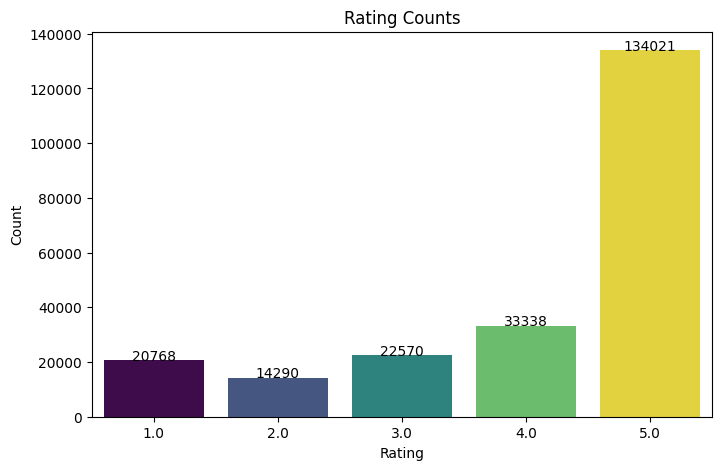

In [38]:
#1. Distribution of Ratings (Count of each rating)
plt.figure(figsize=(8,5))
ax = sns.countplot(x='rating', data=df1,hue='rating', palette='viridis', legend=False)

for p in ax.patches:
    count = int(p.get_height())  # exact count
    ax.text(p.get_x() + p.get_width()/2, count + 5, str(count), ha='center')

plt.title('Rating Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### 2. Distribution of Average Ratings

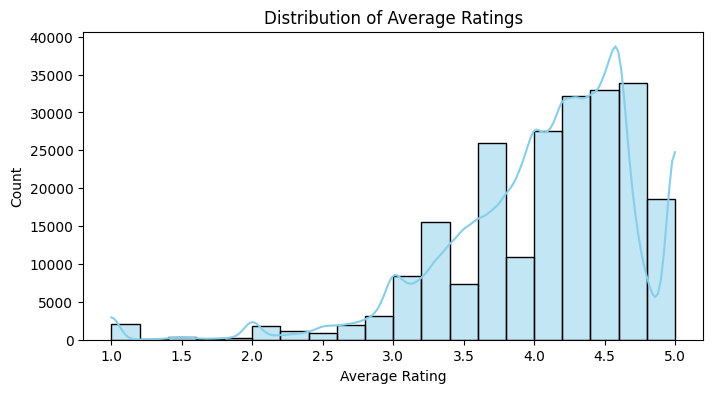

In [39]:
# 2. Distribution of Average Ratings
plt.figure(figsize=(8,4))
sns.histplot(df1['average_rating'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()

### 3. Average Rating Over Time (yearly trend)

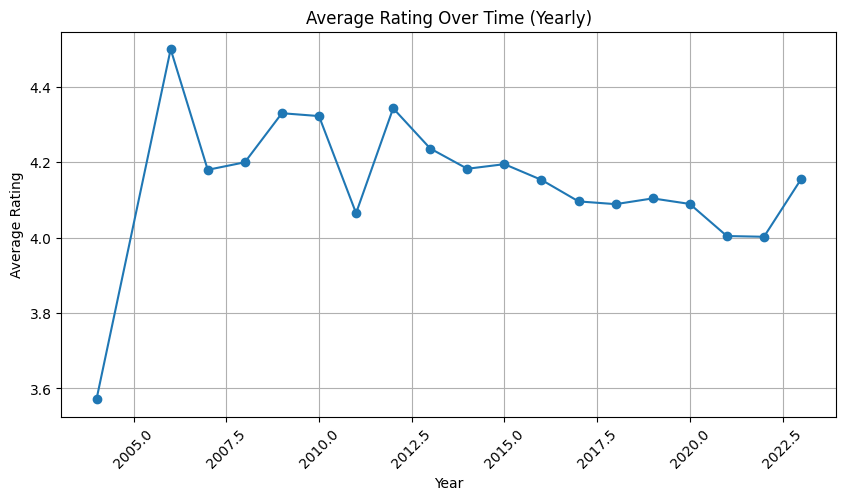

In [40]:
#3. Average Rating Over Time (Monthly trend)
df1['review_date'] = pd.to_datetime(df1['timestamp'], unit='ms')
df1['review_year'] = df1['review_date'].dt.year
rating_over_year = df1.groupby('review_year')['rating'].mean()

# Plot
plt.figure(figsize=(10, 5))
rating_over_year.plot(marker='o', linestyle='-')
plt.title('Average Rating Over Time (Yearly)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



### 4. Top 10 Stores by number of Reviews

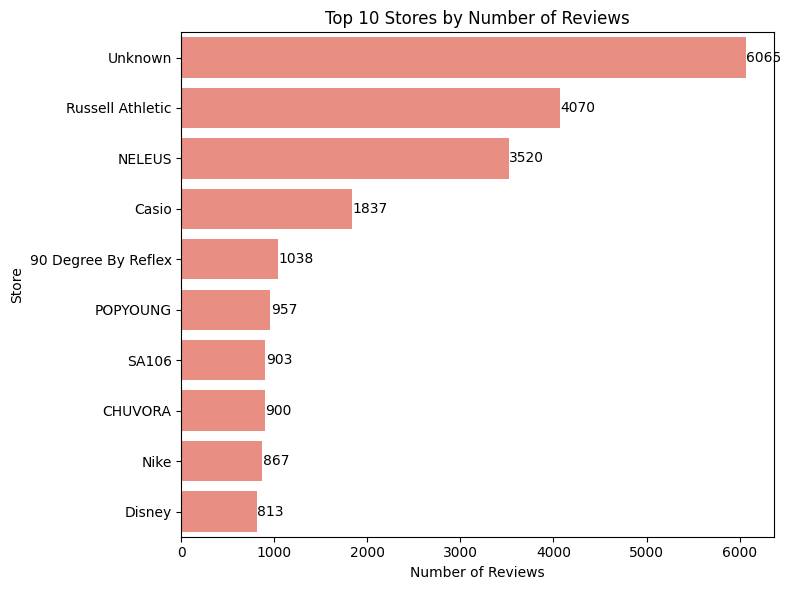

In [41]:
top_stores = df1['store'].value_counts().head(10).sort_values(ascending=False)  # descending order
df_top = df1[df1['store'].isin(top_stores.index)].copy()

df_top['store'] = pd.Categorical(df_top['store'], categories=top_stores.index, ordered=True)

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_top, y='store', color='salmon')

for p in ax.patches:
    count = int(p.get_width())
    ax.text(count + 5, p.get_y() + p.get_height() / 2, str(count), va='center')

plt.title('Top 10 Stores by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Store')
plt.tight_layout()
plt.show()


### 5.  Rating Counts of fashion products

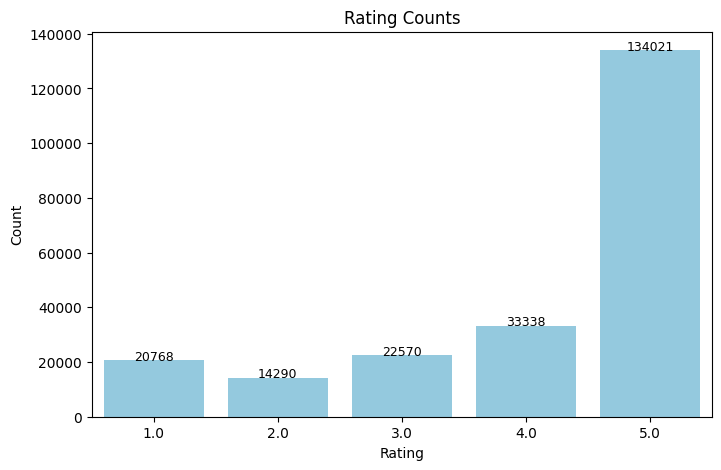

In [42]:
# Countplot of rating with
plt.figure(figsize=(8,5))
ax = sns.countplot(x='rating', data=df1, color='skyblue')

for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width()/2, count + 5, str(count), ha='center', fontsize=9)

plt.title('Rating Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


### 6. Rating Counts and Avg Rating Number (barplot)

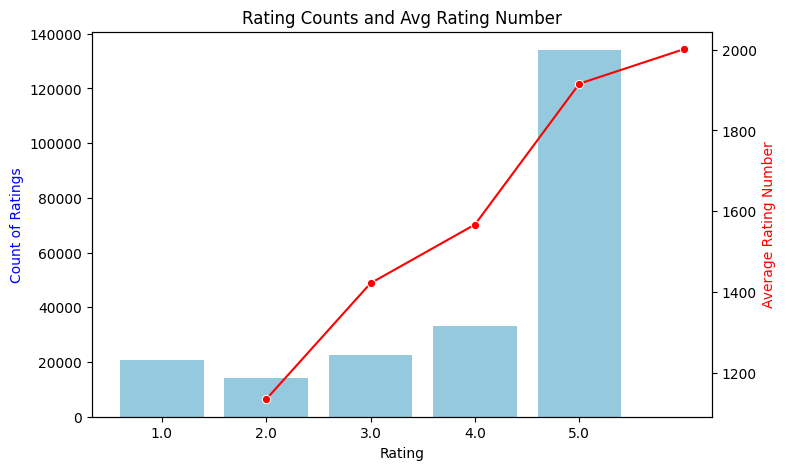

In [43]:
# Rating Counts and Avg Rating Number
agg_df = df1.groupby('rating').agg({'rating': 'count', 'rating_number': 'mean'}).rename(columns={'rating': 'count'}).reset_index()

fig, ax1 = plt.subplots(figsize=(8,5))

sns.barplot(data=agg_df, x='rating', y='count', color='skyblue', ax=ax1)
ax1.set_ylabel('Count of Ratings', color='blue')
ax1.set_xlabel('Rating')

ax2 = ax1.twinx()
sns.lineplot(data=agg_df, x='rating', y='rating_number', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Average Rating Number', color='red')

plt.title('Rating Counts and Avg Rating Number')
plt.show()


### 7. Average Rating by Rating Number Groups

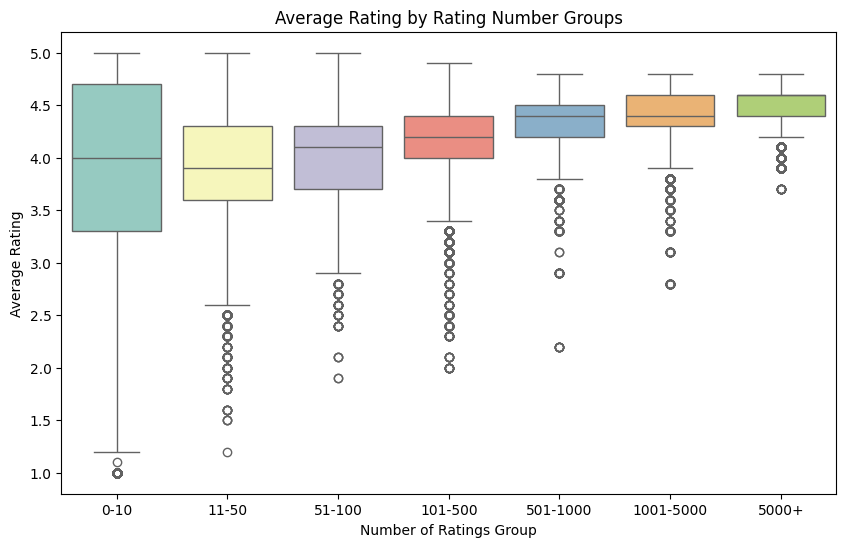

In [44]:
# Create rating bins
df1['rating_bin'] = pd.cut(df1['rating_number'], bins=[0, 10, 50, 100, 500, 1000, 5000, df1['rating_number'].max()],
                            labels=['0-10', '11-50', '51-100', '101-500', '501-1000', '1001-5000', '5000+'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='rating_bin', y='average_rating', data=df1,hue='rating_bin',  palette='Set3',legend=False)
plt.title("Average Rating by Rating Number Groups")
plt.xlabel("Number of Ratings Group")
plt.ylabel("Average Rating")
plt.show()



### 8. Correlation Matrix

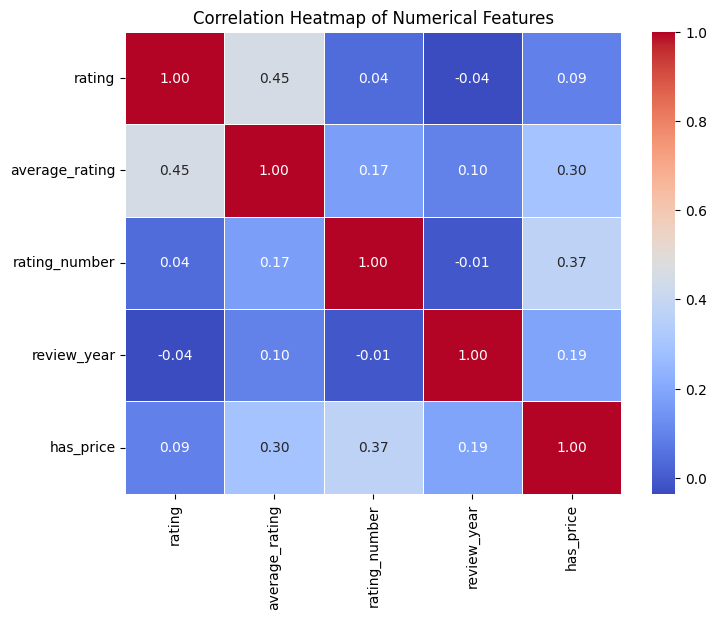

In [45]:
selected_cols = ['rating', 'average_rating', 'rating_number','review_year', 'has_price']  
corr = df1[selected_cols].corr()
# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


## Step 4: Prepare Data for Collaborative Filtering

In [46]:
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

### 1. Data Preparation: Import, Load, Train-Test Split & Sparse Matrix Construction

In [47]:
# Load and clean ratings data
ratings = df1[['user_id', 'asin', 'rating']].dropna()
ratings.columns = ['user_id', 'item_id', 'rating']
ratings = ratings.astype({'user_id': 'category', 'item_id': 'category', 'rating': 'float32'})

# Train-test split
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Create mappings and index columns for train data
user_to_idx = {u: i for i, u in enumerate(train['user_id'].cat.categories)}
item_to_idx = {i: j for j, i in enumerate(train['item_id'].cat.categories)}
train['user_idx'] = train['user_id'].map(user_to_idx)
train['item_idx'] = train['item_id'].map(item_to_idx)

# Map Test Set User & Item IDs to Indices (using train mappings)
test['user_idx'] = test['user_id'].map(user_to_idx)
test['item_idx'] = test['item_id'].map(item_to_idx)

# Create sparse matrix from train data
ratings_matrix = csr_matrix(
    (train['rating'], (train['user_idx'], train['item_idx'])),
    shape=(len(user_to_idx), len(item_to_idx))
)

print("Shape:", ratings_matrix.shape)
print("Non-zero entries:", ratings_matrix.nnz)


Shape: (196307, 113825)
Non-zero entries: 179400


### 2. Compute User and Item Similarity

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(ratings_matrix, dense_output=False) # User-based
item_similarity = cosine_similarity(ratings_matrix.T, dense_output=False) # Item-based


### 3. User-Based & Item-Based CF Prediction Functions

In [49]:
global_mean = train['rating'].mean()

def predict_user_sparse(user_idx, item_idx, k=5):
    users_rated = ratings_matrix[:, item_idx].nonzero()[0]
    sims = user_similarity[user_idx, users_rated].toarray().flatten()
    ratings = ratings_matrix[users_rated, item_idx].toarray().flatten()
    valid = sims > 0
    if not np.any(valid):
        return ratings_matrix[user_idx, :].mean()
    sims, ratings = sims[valid], ratings[valid]
    top_k = sims.argsort()[-k:]
    return np.dot(sims[top_k], ratings[top_k]) / (sims[top_k].sum() + 1e-8)

def predict_item_sparse(user_idx, item_idx, k=5):
    items_rated = ratings_matrix[user_idx, :].nonzero()[1]
    sims = item_similarity[item_idx, items_rated].toarray().flatten()
    ratings = ratings_matrix[user_idx, items_rated].toarray().flatten()
    valid = sims > 0
    if not np.any(valid):
        return ratings_matrix[:, item_idx].mean()
    sims, ratings = sims[valid], ratings[valid]
    top_k = sims.argsort()[-k:]
    return np.dot(sims[top_k], ratings[top_k]) / (sims[top_k].sum() + 1e-8)

### 4. Prepare Test Data for Evaluation

In [50]:
# Map test user_id and item_id to indices using train mappings
test['user_idx'] = test['user_id'].map(user_to_idx)
test['item_idx'] = test['item_id'].map(item_to_idx)

test = test.dropna(subset=['user_idx', 'item_idx'])
test['user_idx'] = test['user_idx'].astype(int) # Convert to int after dropping NaNs
test['item_idx'] = test['item_idx'].astype(int)

# Display a sample of the mapped test data
print(test[['user_id', 'item_id', 'user_idx', 'item_idx']].head())


                             user_id     item_id  user_idx  item_idx
14961   AEVJR5QHUXVMWGK37OXBRAUKLAQQ  B00VFKKDGK     42377     13449
128071  AEM6UB6W7ECY3WTNIRH3YFF46DUQ  B0793FKVPG     27840     52935
202311  AE5TNU27I7ZWE2QYZBPNE7S7QKKQ  B01J0SC9J2      5824     29591
180843  AGCJ7DPLLIJ2AJJRWR7XETXLOOOQ  B08GSCDV3P    111132     92504
145108  AF5KCLPUK3BPWUHZ3WHX2PASOZTA  B07S7NSWJ9     54602     74305


### ** Prepare Test Data for Evaluation

In [51]:
# Example: Predict ratings for first 5 test samples using User- and Item-based CF

for i in range(5):
    u_id = test.iloc[i]['user_id']   # original user id
    i_id = test.iloc[i]['item_id']   # original item id
    
    # Check if user and item exist in training mappings
    if u_id in user_to_idx and i_id in item_to_idx:
        uid = user_to_idx[u_id]       # mapped user index
        iid = item_to_idx[i_id]       # mapped item index
        
        # Predict using User-based CF
        pred_user = predict_rating_user(user_similarity, ratings_matrix, uid, iid)
        # Predict using Item-based CF
        pred_item = predict_rating_item(item_similarity, ratings_matrix, uid, iid)
        
        print(f"User-based pred: {pred_user:.4f}, Item-based pred: {pred_item:.4f}")
    else:
        # Fallback prediction when user/item not in train set
        print("User or item not in training data. Using global mean.")
        print(f"Pred: {global_mean:.4f}")


NameError: name 'predict_rating_user' is not defined

### 5. Evaluate User-Based Collaborative Filtering

In [ ]:
def user_based_pred(user_idx, item_idx):
    sim_scores = user_similarity[user_idx, :].toarray().flatten()
    item_ratings = ratings_matrix[:, item_idx].toarray().flatten()
    rated_users = np.where(item_ratings > 0)[0]
    if len(rated_users) == 0:
        return global_mean
    sim_scores_rated = sim_scores[rated_users]
    ratings_rated = item_ratings[rated_users]
    if np.sum(sim_scores_rated) == 0:
        return global_mean
    return np.dot(sim_scores_rated, ratings_rated) / np.sum(sim_scores_rated)

test['pred_user_cf'] = test.apply(lambda r: user_based_pred(r['user_idx'], r['item_idx']), axis=1)

rmse_user_cf = np.sqrt(mean_squared_error(test['rating'], test['pred_user_cf']))
mae_user_cf = mean_absolute_error(test['rating'], test['pred_user_cf'])

print(f"User-Based CF RMSE: {rmse_user_cf:.4f}")
print(f"User-Based CF MAE: {mae_user_cf:.4f}")

User-Based CF RMSE: 1.3333
User-Based CF MAE: 1.0804


### 6. SVD (Matrix Factorization)

In [ ]:
svd = TruncatedSVD(n_components=20, random_state=42)
user_factors_svd = svd.fit_transform(ratings_matrix)
item_factors_svd = svd.components_.T

# Predict function without full matrix reconstruction
def predict_svd(u_idx, i_idx):
    if u_idx < user_factors_svd.shape[0] and i_idx < item_factors_svd.shape[0]:
        return np.dot(user_factors_svd[u_idx], item_factors_svd[i_idx])
    else:
        return global_mean

test['pred_svd'] = test.apply(lambda r: predict_svd(r['user_idx'], r['item_idx']), axis=1)

print("SVD RMSE:", np.sqrt(mean_squared_error(test['rating'], test['pred_svd'])))
print("SVD MAE:", mean_absolute_error(test['rating'], test['pred_svd']))


SVD RMSE: 4.301778097462105
SVD MAE: 4.088999271392822


### 7.NMF (Matrix Factorization)

In [ ]:

nmf = NMF(n_components=20, init='random', random_state=42)
user_factors_nmf = nmf.fit_transform(ratings_matrix)
item_factors_nmf = nmf.components_.T

def predict_nmf(u_idx, i_idx):
    if u_idx < user_factors_nmf.shape[0] and i_idx < item_factors_nmf.shape[0]:
        return np.dot(user_factors_nmf[u_idx], item_factors_nmf[i_idx])
    else:
        return global_mean

test['pred_nmf'] = test.apply(lambda r: predict_nmf(r['user_idx'], r['item_idx']), axis=1)

print("NMF RMSE:", np.sqrt(mean_squared_error(test['rating'], test['pred_nmf'])))
print("NMF MAE:", mean_absolute_error(test['rating'], test['pred_nmf']))

NMF RMSE: 4.301787851945344
NMF MAE: 4.089009761810303


### 8. Precision@K Evaluation for SVD and NMF Models

In [ ]:
def precision_at_k(test_df, user_factors, item_factors, user_to_idx, item_to_idx, k=10, threshold=4):
    precisions = []
    for user_id, group in test_df.groupby('user_id', observed=False):
        if user_id not in user_to_idx:
            continue
        uidx = user_to_idx[user_id]
        test_items = [i for i in group['item_id'] if i in item_to_idx]
        if not test_items:
            continue
        preds = [np.dot(user_factors[uidx], item_factors[item_to_idx[i]]) for i in test_items]
        top_k = np.argsort(preds)[-k:]
        relevant = set(group[group['rating'] >= threshold]['item_id'])
        hits = sum(test_items[i] in relevant for i in top_k)
        precisions.append(hits / k)
    return np.mean(precisions)

print("SVD Precision@10:", precision_at_k(test, user_factors_svd, item_factors_svd, user_to_idx, item_to_idx))
print("NMF Precision@10:", precision_at_k(test, user_factors_nmf, item_factors_nmf, user_to_idx, item_to_idx))

SVD Precision@10: 0.07716393820613326
NMF Precision@10: 0.07716393820613326


### 9. Content-Based Filtering on meta data (TF-IDF)

In [ ]:
# Combine text fields
df1['combined_text'] = df1[['title_y', 'features', 'description']].fillna('').agg(' '.join, axis=1)

df_items = df1.drop_duplicates(subset='asin')[['asin', 'combined_text']].reset_index(drop=True)
item_id_to_idx = pd.Series(df_items.index, index=df_items['asin']).to_dict()

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_items['combined_text'])
#cosine_sim = cosine_similarity(item_features)

# Similarity using Nearest Neighbors
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

def get_similar_items(item_asin, top_n=5):
    if item_asin not in item_id_to_idx:
        return []
    idx = item_id_to_idx[item_asin]
    distances, indices = nn.kneighbors(tfidf_matrix[idx], n_neighbors=top_n+1)
    similar_indices = indices.flatten()[1:]  # Skip self
    return [df_items.iloc[i]['asin'] for i in similar_indices]

# Example
print("Similar items to first item:", get_similar_items(df_items.iloc[0]['asin']))


Similar items to first item: ['B012BKUJR0', 'B083QNWRH3', 'B00V3K1AAA', 'B00FKVWIF4', 'B009CK9YOW']


### 10. hybrid_recommendations

In [59]:
# Combine text fields into a single column for content-based filtering
df1['combined_text'] = df1[['title_y', 'features', 'description']].fillna('').agg(' '.join, axis=1)

# Filter distinct items and keep necessary columns
df_items = df1.drop_duplicates(subset='asin')[['asin', 'combined_text']].reset_index(drop=True)


In [ ]:
# TF-IDF Vectorization + Nearest Neighbors model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# TF-IDF Vectorizer with reduced dimensions for memory efficiency
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf.fit_transform(df_items['combined_text'])

# Fit Nearest Neighbors model using cosine similarity
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# Mappings
item_id_to_idx = {asin: idx for idx, asin in enumerate(df_items['asin'])}
idx_to_item_id = {idx: asin for asin, idx in item_id_to_idx.items()}

# Get similar items
def get_similar_items(asin, top_k=10):
    if asin not in item_id_to_idx: return []
    idx = item_id_to_idx[asin]
    _, indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=top_k+1)
    return [idx_to_item_id[i] for i in indices[0] if i != idx][:top_k]


In [62]:
# 3. Modified hybrid_recommendations()

def hybrid_recommendations(user_id, top_n=10, alpha=0.5):
    if user_id not in user_to_idx:
        return []

    user_idx = user_to_idx[user_id]
    rated_items = train[train['user_idx'] == user_idx]['item_idx'].tolist()
    rated_asins = [train[train['item_idx'] == i]['item_id'].iloc[0] for i in rated_items]

    scores = {}
    for asin in df_items['asin']:
        if asin in rated_asins: continue
        item_idx = item_to_idx.get(asin)
        if item_idx is None: continue

        # CF score (mean user rating for item)
        cf_score = ratings_matrix[user_idx, item_idx] if ratings_matrix[user_idx, item_idx] != 0 else 0

        # CBF score: average similarity to items user has rated
        sim_items = get_similar_items(asin, top_k=10)
        sim_scores = []
        for r_asin in rated_asins:
            r_idx = item_id_to_idx.get(r_asin)
            a_idx = item_id_to_idx.get(asin)
            if r_idx is not None and a_idx is not None:
                sim = 1 - nn_model.kneighbors(tfidf_matrix[a_idx], n_neighbors=11)[0][0][1]  # 1 - distance
                sim_scores.append(sim)
        cbf_score = sum(sim_scores) / len(sim_scores) if sim_scores else 0

        # Final hybrid score
        scores[asin] = alpha * cf_score + (1 - alpha) * cbf_score

    top_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [asin for asin, _ in top_items]


In [65]:
def hybrid_recommendations_fast(user_id, top_n=10, alpha=0.5):
    if user_id not in user_to_idx:
        return []

    user_idx = user_to_idx[user_id]
    
    # Items already rated
    rated_indices = ratings_matrix[user_idx].nonzero()[1]
    rated_asins = train[train['item_idx'].isin(rated_indices)]['item_id'].unique()

    # Content-based: similarity scores for all items (precompute for efficiency)
    mean_sim_scores = np.zeros(tfidf_matrix.shape[0])

    for r_asin in rated_asins:
        if r_asin not in item_id_to_idx:
            continue
        r_idx = item_id_to_idx[r_asin]
        _, indices = nn_model.kneighbors(tfidf_matrix[r_idx], n_neighbors=20)
        for i in indices[0]:
            mean_sim_scores[i] += 1
    mean_sim_scores /= len(rated_asins)

    # Collaborative filtering score: raw ratings_matrix
    cf_scores = ratings_matrix[user_idx].toarray().flatten()

    # Hybrid score
    hybrid_score = alpha * cf_scores + (1 - alpha) * mean_sim_scores

    # Remove already rated items
    hybrid_score[rated_indices] = -1

    # Top-N recommendations
    top_indices = hybrid_score.argsort()[::-1][:top_n]
    return [df_items.iloc[i]['asin'] for i in top_indices if i < len(df_items)]


In [67]:
import random
user = random.choice(train['user_id'].unique())
print("Recommendations:", hybrid_recommendations_fast(user, top_n=10))


Recommendations: ['B07D3RSN51', 'B08JQJN68M', 'B07VRS9BLR', 'B07SDRQ6TR', 'B00NPH8E94', 'B06WRSWY8K', 'B01ET8YF6I', 'B01JRYELL8', 'B01IR1FMHY', 'B074X4SJWM']


## Conclusion